# 1 -Imports

In [26]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# 2- Conexao com o banco 

In [27]:
conn = sqlite3.connect('/Users/User/Documents/repos/case_workana/dastabase.sqlite')

# 3- Metricas de engajamento



## 3.1 - Total de mensagens trocadas
### O total de mensagens trocadas entre os dois grupos é bem similar. Métrica inconclusiva para identificar melhoria de performance.

In [28]:
query_nivel_engajamento = '''
-- query que as somas de mensagens trocadas por projeto dos do teste
select
a.id as project_id,
coalesce(avg(total_messages),0) as avg_total_messages,
a.segment
from 
abtests as a
left join
threads as b on a.project_id = b.project_id
where
1=1
and created_at between '03/07/2025' and '21/07/2025'
group by 
a.id,
a.segment




'''

In [29]:
df_nivel_engajamento = pd.read_sql(query_nivel_engajamento, con=conn)

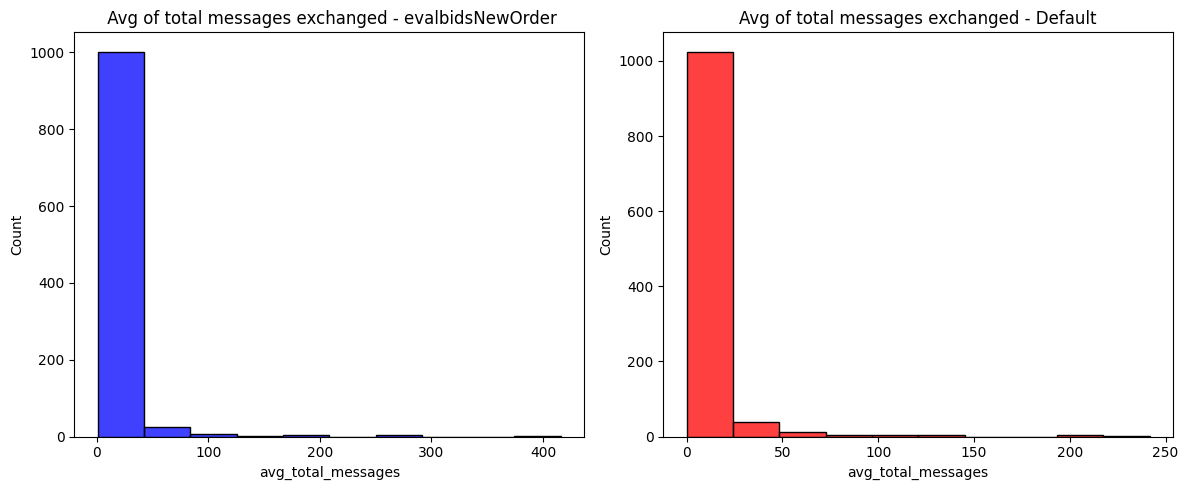

In [30]:
df_nivel_engajamento_evalbids = df_nivel_engajamento[df_nivel_engajamento['segment'] == 'evalbidsNewOrder']
df_nivel_engajamento_default = df_nivel_engajamento[df_nivel_engajamento['segment'] == 'default']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df_nivel_engajamento_evalbids, x='avg_total_messages', bins=10, color='blue')
plt.title(' Avg of total messages exchanged - evalbidsNewOrder')

plt.subplot(1, 2, 2)
sns.histplot(data=df_nivel_engajamento_default, x='avg_total_messages', bins=10, color='red')
plt.title('Avg of total messages exchanged - Default')

plt.tight_layout()
plt.show()

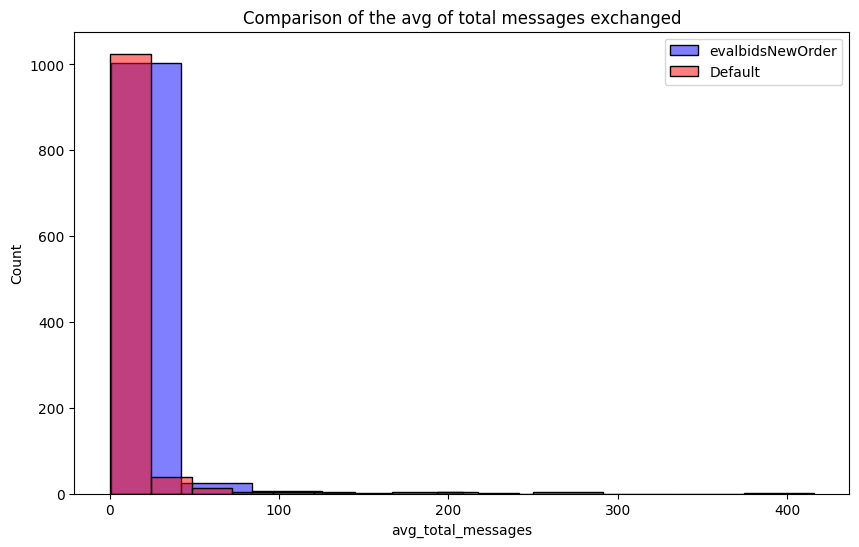

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_nivel_engajamento_evalbids, x='avg_total_messages', bins=10, 
             color='blue', alpha=0.5, label='evalbidsNewOrder')
sns.histplot(data=df_nivel_engajamento_default, x='avg_total_messages', bins=10,
             color='red', alpha=0.5, label='Default')
plt.title('Comparison of the avg of total messages exchanged')
plt.legend()
plt.show()

## 3.2 - Total de mensagens por bids aceitos

### Mais mensagens em media trocadas em bids aceitos do grupo de CONTROLE do que o grupo de teste. Isso contesta diretamente o resultado do teste, pois o engajamento do grupo de controle para bids acetis foi maior.

In [32]:
query_engajamento_por_bids_aceitos = ''' 

with tb_accepted_bids as (
-- cte com os bids aceitos e as datas para filtro (as datas vem da tabela de bids)
	select 
        a.bid_id,
        b.project_id, 
        1 as flg_accepted_bid,
        b.created_date
    from 
        accepted_bids as a
    left join 
        bids as b on a.bid_id = b.id
    where 
        1=1
        and b.created_date between '03-07-2025' and '21-07-2025' 
        and a.status = 'active'
        and b.id is not null 
)

select
a.project_id,
a.segment,
coalesce(avg(total_messages),0) as avg_total_messages
from 
abtests as a
left join
threads as b on a.project_id = b.project_id and b.created_at between '03/07/2025' and '21/07/2025'
inner join 
tb_accepted_bids as c on a.project_id = c.project_id
group by 
a.id,
a.segment

'''

In [33]:
df_nivel_engajamento_por_bids_aceitos = pd.read_sql(query_engajamento_por_bids_aceitos, con=conn)

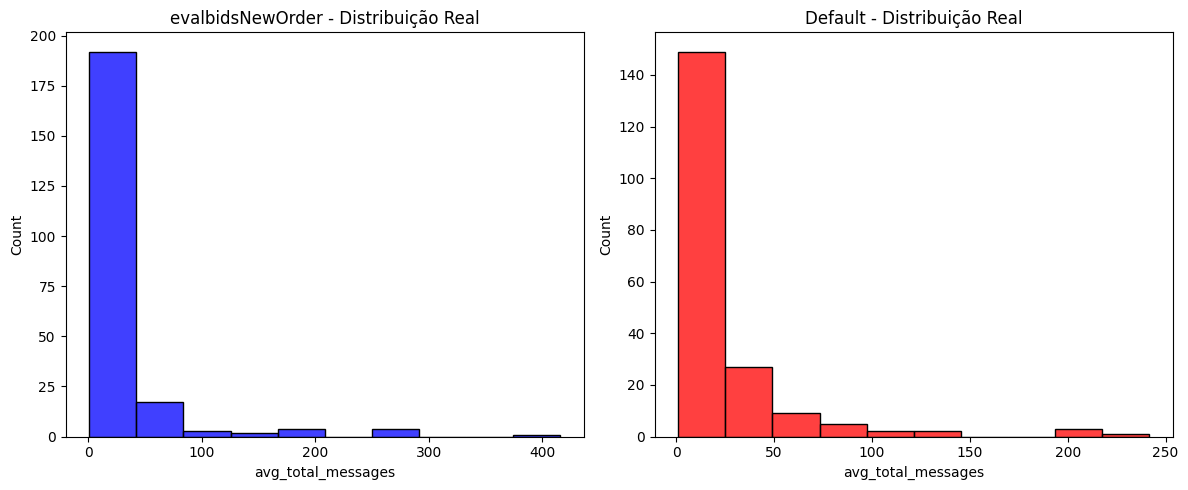

In [34]:
df_nivel_engajamento_por_bids_aceitos_evalbids = df_nivel_engajamento_por_bids_aceitos[df_nivel_engajamento_por_bids_aceitos['segment'] == 'evalbidsNewOrder']
df_nivel_engajamento_por_bids_aceitos_default = df_nivel_engajamento_por_bids_aceitos[df_nivel_engajamento_por_bids_aceitos['segment'] == 'default']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df_nivel_engajamento_por_bids_aceitos_evalbids, x='avg_total_messages', bins=10, color='blue')
plt.title('evalbidsNewOrder - Distribuição Real')

plt.subplot(1, 2, 2)
sns.histplot(data=df_nivel_engajamento_por_bids_aceitos_default, x='avg_total_messages', bins=10, color='red')
plt.title('Default - Distribuição Real')

plt.tight_layout()
plt.show()

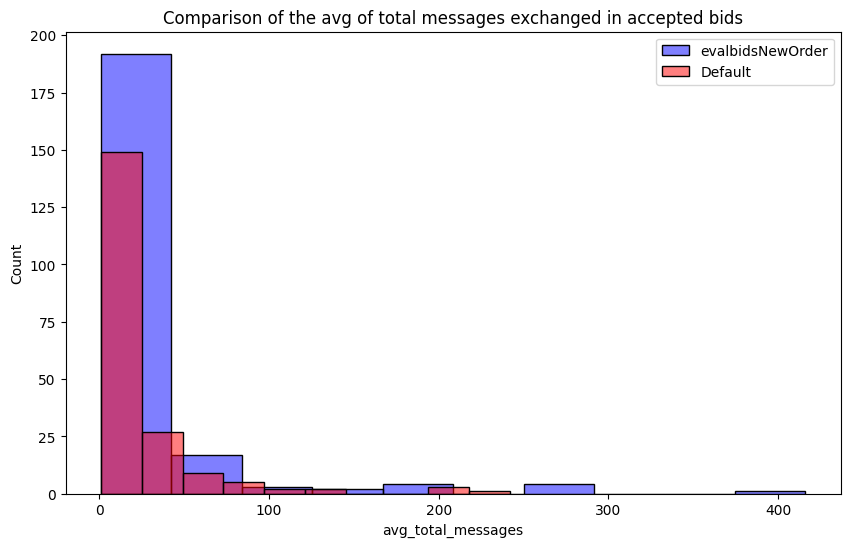

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_nivel_engajamento_por_bids_aceitos_evalbids, x='avg_total_messages', bins=10, 
             color='blue', alpha=0.5, label='evalbidsNewOrder')
sns.histplot(data=df_nivel_engajamento_por_bids_aceitos_default, x='avg_total_messages', bins=10,
             color='red', alpha=0.5, label='Default')
plt.title('Comparison of the avg of total messages exchanged in accepted bids')
plt.legend()
plt.show()

## 3.3 - Average messages per day 

In [36]:
query_average_messages_per_day = '''

SELECT
    a.segment,
    b.created_at as date,
    CAST(COALESCE(AVG(b.total_messages), 0) AS INT) as avg_messages_per_day,
    COUNT(DISTINCT a.id) as total_projects
FROM 
    abtests as a
LEFT JOIN
    threads as b ON a.project_id = b.project_id
WHERE 
    b.created_at IS NOT NULL
    and created_at between '03/07/2025' and '21/07/2025'
GROUP BY 
    a.segment,
    b.created_at
ORDER BY
    a.segment,
    b.created_at
    
'''

In [59]:
df_average_messages_per_day = pd.read_sql(query_average_messages_per_day, con=conn)


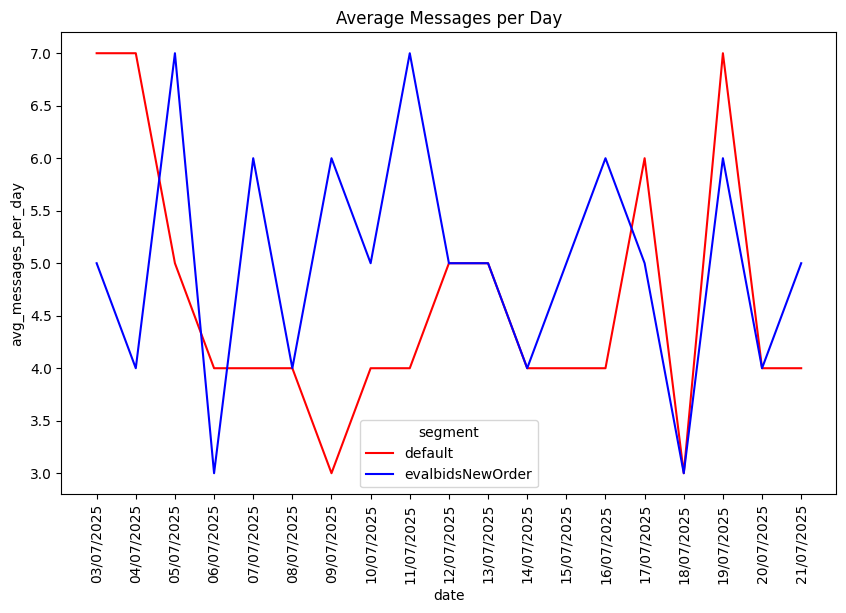

In [60]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_average_messages_per_day, x='date', y='avg_messages_per_day', hue='segment', palette=['red', 'blue'])
# Comando para definir o título
plt.title('Average Messages per Day')
plt.xticks(rotation=90)
plt.show()

## 3.4 - Projects by EL1

# A quantidade de projetos com propostas de cliente (EL1) é similar para o grupo teste e controle

In [39]:
query_projects_by_elq = ''' 

SELECT
    a.segment,
    CASE
        WHEN b.el1 IS NULL THEN 'NOT IDENTIFIED' 
        when b.el1 = 'VERDADEIRO' then 'TRUE'
        when b.el1 = 'FALSO' then 'FALSE'
        END as el1,
    COUNT(a.project_id) as qtd,
    100.0 * COUNT(a.project_id) / SUM(COUNT(a.project_id)) OVER (PARTITION BY a.segment) as el1_rate
FROM 
    abtests as a
LEFT JOIN
    projects as b ON a.project_id = b.id
GROUP BY 
    a.segment,
    b.el1

'''

In [62]:
df_average_messages_per_day = pd.read_sql(query_projects_by_elq, con=conn)


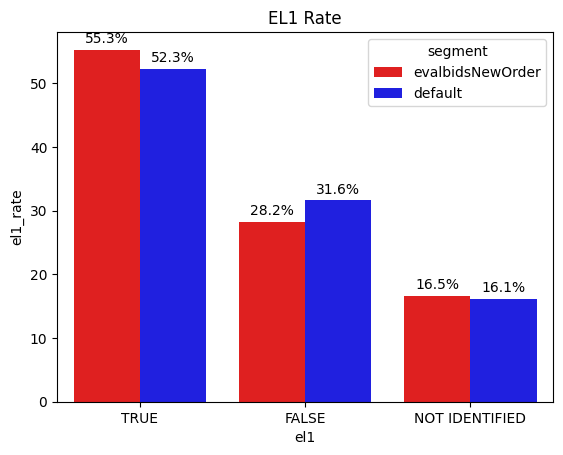

In [63]:
df_average_messages_per_day_sorted = df_average_messages_per_day.sort_values(by='el1_rate', ascending=False)
ax = sns.barplot(data=df_average_messages_per_day_sorted, x='el1', y='el1_rate', hue='segment', palette=['red', 'blue'])
plt.title('EL1 Rate')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=10, padding=3)

## 3.5 Acceptance rate by gamification level

### As taxas de bids aceitos para grupos de gamificação mais elevados do grupo teste foram melhores, ponto positivo para o teste. O proximo passo seria executar outro teste ab com esse score para usuarios com gamificaçao mais elevada?

In [42]:
query_acceptancte_rate_by_gamification_level = '''


with tb_accepted_bids as (
-- cte com os bids aceitos e as datas para filtro (as datas vem da tabela de bids)
	select 
        a.bid_id,
        b.project_id, 
        1 as flg_accepted_bid,
        b.created_date,
		a.worker_position_gamification
    from 
        accepted_bids as a
    left join 
        bids as b on a.bid_id = b.id
    where 
        1=1
        and b.created_date between '03-07-2025' and '21-07-2025' 
        and a.status = 'active'
        and b.id is not null 
),

total_projects_by_segment AS (
    SELECT 
        segment,
        COUNT(project_id) AS total_projects
    FROM 
        abtests
    GROUP BY 
        segment
)

SELECT
    a.segment,
    COALESCE(b.worker_position_gamification, 'NO BID ACCEPTED') AS worker_position_gamification,
    COUNT(b.project_id) AS accepted_bids_count,
    tp.total_projects AS total_projects_in_segment,
    ROUND(100.0 * COUNT(b.project_id) / tp.total_projects, 2) AS acceptance_rate
FROM 
    abtests AS a
LEFT JOIN 
    tb_accepted_bids AS b ON a.project_id = b.project_id
LEFT JOIN
    total_projects_by_segment AS tp ON a.segment = tp.segment
GROUP BY 
    a.segment,
    b.worker_position_gamification,
    tp.total_projects
ORDER BY
    a.segment,
    acceptance_rate DESC;

    
'''

In [65]:
df_average_messages_per_day = pd.read_sql(query_acceptancte_rate_by_gamification_level, con=conn)


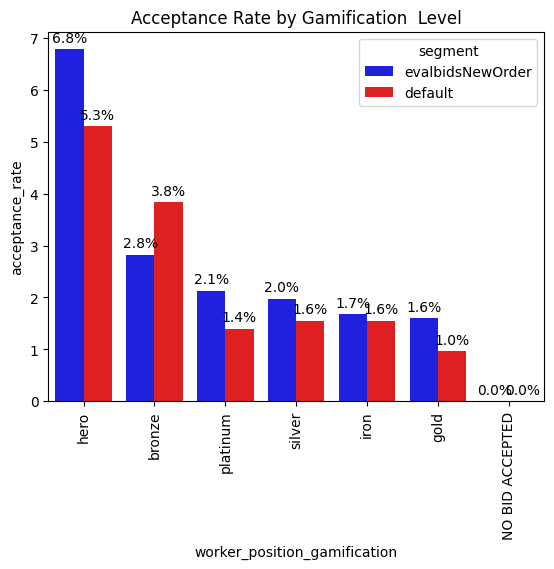

In [66]:
df_average_messages_per_day = df_average_messages_per_day.sort_values(by='acceptance_rate', ascending=False)
ax = sns.barplot(data=df_average_messages_per_day, x='worker_position_gamification', y='acceptance_rate', hue='segment', palette=['blue', 'red'])
plt.title('Acceptance Rate by Gamification  Level')
plt.xticks(rotation=90)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=10, padding=3)

## 3.6 Days between project posting and acceptance bid

# Mais projetos foram fechados no mesmo dia para usuarios hero e gold no grupo de teste. Ponto de reforço do desempenho positivo do teste.

In [45]:
query_days_between_project_posting_and_acceptance_bid = '''

with tb_accepted_bids as (
-- cte com os bids aceitos e as datas para filtro (as datas vem da tabela de bids)
	select 
        a.bid_id,
        b.project_id, 
        1 as flg_accepted_bid,
        b.created_date,
		a.worker_position_gamification,
		a.date_paid_on
    from 
        accepted_bids as a
    left join 
        bids as b on a.bid_id = b.id
    where 
        1=1
        and b.created_date between '03-07-2025' and '21-07-2025' 
        and a.status = 'active'
        and b.id is not null 
)

select 
a.*,
b.worker_position_gamification,
case 
	when date_paid_on - created_date = 0 then '0 days'
	when date_paid_on - created_date = 1 then '1 day'
    when date_paid_on - created_date = 2 then '2 days'
    when date_paid_on - created_date = 3 then '3 days'
    when date_paid_on - created_date = 4 then '4 days'
	when date_paid_on - created_date >= 5 then '5 or more days' 
end as dif_dates_in_days
from 
abtests as a
left join 
tb_accepted_bids as b on a.project_id = b.project_id
where 
1=1
and date_paid_on is not null

'''

In [46]:
df_days_between_project_posting_and_acceptance_bid = pd.read_sql(query_days_between_project_posting_and_acceptance_bid, con=conn)


In [47]:
df_days_between_project_posting_and_acceptance_bid

,id,project_id,name,segment,created,worker_position_gamification,dif_dates_in_days
0,8363322,3155349,evalbidsNewRelevanceOrder,default,"2025-7-3, 09:40",hero,0 days
1,8363657,3155460,evalbidsNewRelevanceOrder,default,"2025-7-3, 11:07",bronze,4 days
2,8363863,3155523,evalbidsNewRelevanceOrder,evalbidsNewOrder,"2025-7-3, 11:56",hero,0 days
3,8363867,3155524,evalbidsNewRelevanceOrder,evalbidsNewOrder,"2025-7-3, 11:58",hero,0 days
4,8363997,3155571,evalbidsNewRelevanceOrder,evalbidsNewOrder,"2025-7-3, 12:33",silver,0 days
...,...,...,...,...,...,...,...
365,8429652,3172748,evalbidsNewRelevanceOrder,evalbidsNewOrder,"2025-7-20, 13:03",hero,2 days
366,8429814,3172796,evalbidsNewRelevanceOrder,evalbidsNewOrder,"2025-7-20, 14:03",gold,1 day
367,8430616,3172994,evalbidsNewRelevanceOrder,default,"2025-7-20, 19:41",iron,1 day
368,8430735,3173030,evalbidsNewRelevanceOrder,default,"2025-7-20, 20:26",bronze,0 days


C:\Users\User\AppData\Local\Temp\ipykernel_11500\3502336018.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\User\AppData\Local\Temp\ipykernel_11500\3502336018.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


TypeError: 'Axes' object is not subscriptable

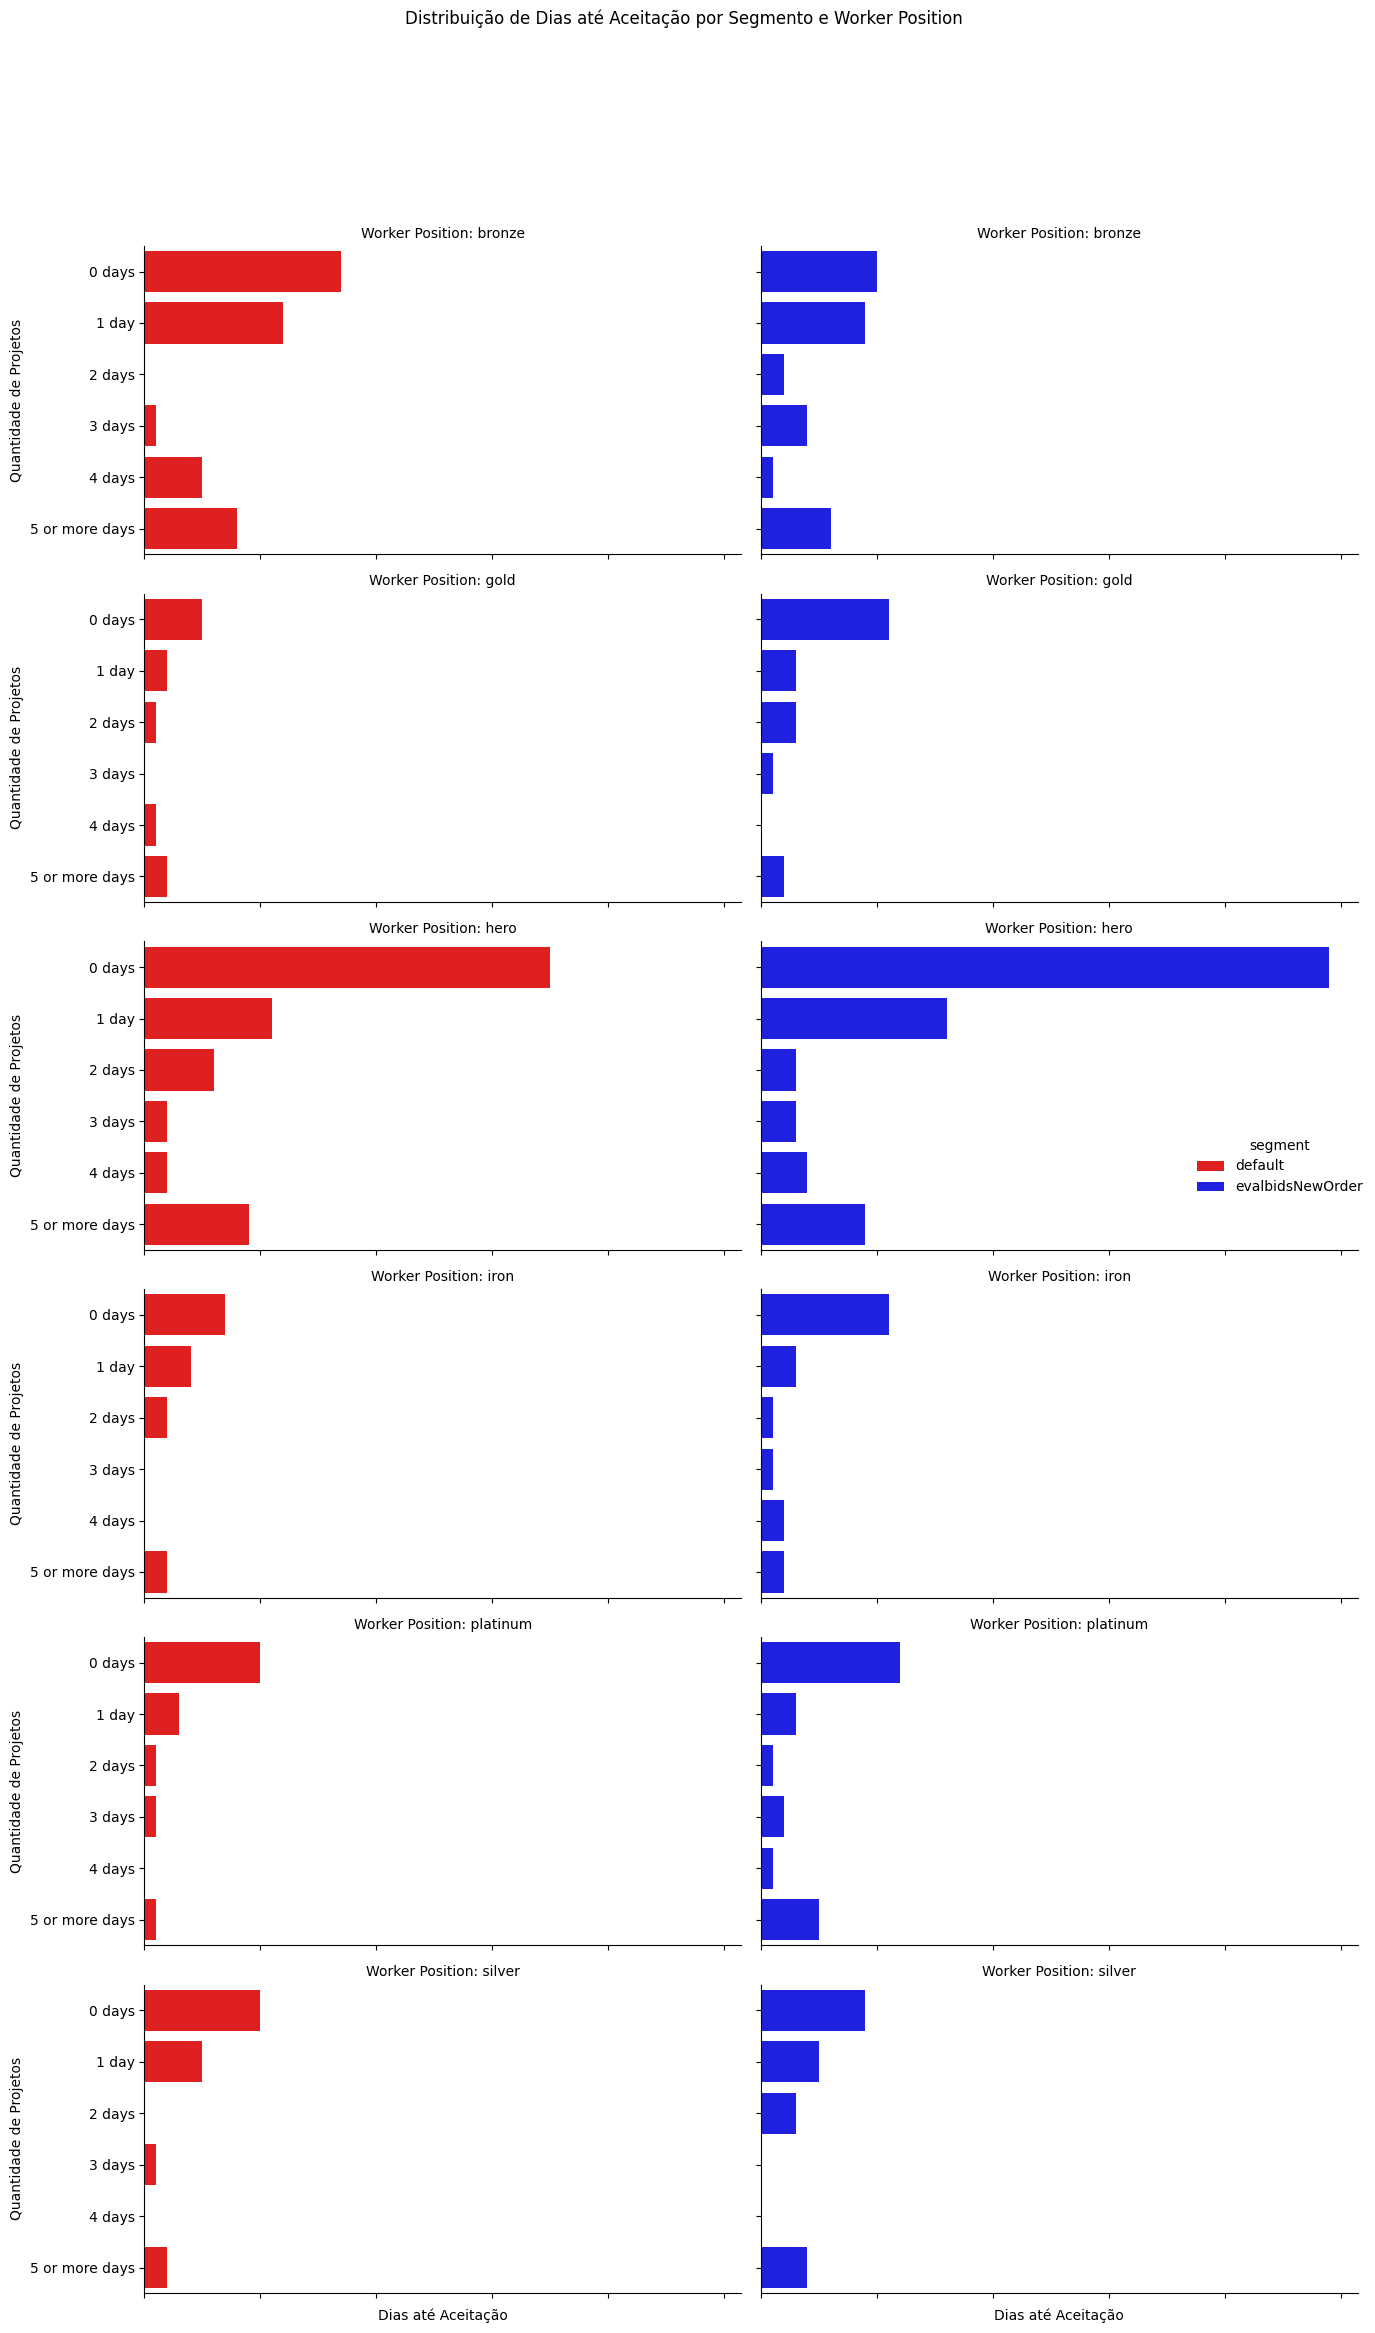

In [48]:
ax = df_days_between_project_posting_and_acceptance_bid[['dif_dates_in_days', 'project_id', 'segment', 'worker_position_gamification']].groupby(['dif_dates_in_days', 'segment', 'worker_position_gamification']).count().reset_index()

g = sns.catplot(
    data=ax, 
    x='project_id', 
    y='dif_dates_in_days', 
    hue='segment',
    col='segment',
    row='worker_position_gamification',
    kind='bar', 
    palette=['red', 'blue'],
    height=4, 
    aspect=1.5  # Aumenta o aspect ratio para dar mais espaço horizontal
)

g.set_titles("Worker Position: {row_name}")
g.set_axis_labels("Dias até Aceitação", "Quantidade de Projetos")

# Configuração mais agressiva para ver os labels
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45, labelsize=8)  # Reduz tamanho da fonte também
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

g.fig.suptitle('Distribuição de Dias até Aceitação por Segmento e Worker Position', y=1.02)

# Ajusta o layout com mais margem inferior
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Aumenta espaço na parte inferior

print("Valores únicos de dias:", sorted(ax['dif_dates_in_days'].unique()))
plt.show()

In [ ]:
ax = df_days_between_project_posting_and_acceptance_bid[['dif_dates_in_days', 'project_id', 'segment', 'worker_position_gamification']].groupby(['dif_dates_in_days', 'segment', 'worker_position_gamification']).count().reset_index()


plt.Figure(figsize=(20,20))
g = sns.catplot(
    data=ax, 
    x='dif_dates_in_days', 
    y='project_id', 
    hue='segment',
    col='segment',  # Segmenta por worker_position
    row='worker_position_gamification',  # Ou use row para segment
    kind='bar', 
    palette=['red', 'blue'],
    height=4, 
    aspect=1.2
)


g.set_titles("Worker Position: {row_name}")  # Rótulo das colunas
g.set_axis_labels("Dias até Aceitação", "Quantidade de Projetos")  # Rótulos dos eixos
g.set_xticklabels(rotation=90)
g.fig.suptitle('Distribuição de Dias até Aceitação por Segmento e Worker Position', y=1.02)

plt.tight_layout()
plt.show()


KeyError: "['dif_dates_in_days', 'project_id'] not in index"